In [1]:
from fileToolbox import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
set_of_person_ids = set(train_df["person_id"])
list_of_unique_person_ids = list(set_of_person_ids)

In [11]:
def runDecTreeClassifierGridSearch(dataFrame_for_one_person):
    X = [createFeatureVectorForMovie(value) for value in dataFrame_for_one_person["movie_id"]]
    y = dataFrame_for_one_person["rate"]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the scaler and normalize the training data
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train) # tu fit_transform bo scaler musi najpierw sfitować do danych

    # Use the same scaler to normalize the test data
    X_test_normalized = scaler.transform(X_test) # tu samo transform bo już jest sfitowany na danych treningowych
    
    # Initialize the Decision Tree Classifier
    decision_tree_classifier = DecisionTreeClassifier(random_state=42)

    # Define the parameter grid for GridSearchCV
    param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': [None, 25, 50, 100], 'max_features': ['auto', 'sqrt', 'log2']}

    # Create the GridSearchCV object
    grid_search = GridSearchCV(decision_tree_classifier, param_grid, cv=5, scoring='accuracy')

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train_normalized, y_train)

    # Print the best parameters and corresponding accuracy
#     print("Best Parameters:", grid_search.best_params_)
#     print("Best Accuracy:", grid_search.best_score_)

    # Make predictions on the test set using the best model
    best_tree_model = grid_search.best_estimator_
    y_pred = best_tree_model.predict(X_test_normalized)

    # Evaluate the accuracy of the best model on the test set
    accuracy = best_tree_model.score(X_test_normalized, y_test)
    
    return list(dataFrame_for_one_person["person_id"])[0], round(accuracy, 2), grid_search.best_params_["criterion"], grid_search.best_params_["splitter"], grid_search.best_params_["max_depth"], grid_search.best_params_["max_features"]


In [12]:
json_list = []
for person in list_of_unique_person_ids:
    person_id, accuracy, criterion, splitter, max_depth, max_features = runDecTreeClassifierGridSearch(filterDataFrame("person_id", person, train_df))
    json_list.append({'person_id': person_id, 'accuracy': accuracy, 'criterion': criterion, 'splitter': splitter, 'max_depth': max_depth, 'max_features': max_features})

In [13]:
# Convert the list to a JSON-formatted string
json_data = json.dumps(json_list, indent=2)

# Save the JSON data to a file
with open('json/decisionTreeParams.json', 'w') as file:
    json.dump(json_list, file, indent=2)

In [14]:
accuracies = []
for elem in json_list:
    accuracies.append(elem['accuracy'])

In [15]:
print(min(accuracies))
print(max(accuracies))
print(sum(accuracies) / len(accuracies))

0.0
1.0
0.3881284916201116


In [27]:
def runDecisionTreeClassifier(dataFrame_for_one_person, new_movie_to_predict, criterion, splitter, max_depth, max_features):
    X = [createFeatureVectorForMovie(value) for value in dataFrame_for_one_person["movie_id"]]
    y = dataFrame_for_one_person["rate"]
    
    # film poddawany predykcji
    new_movie_to_predict = createFeatureVectorForMovie(new_movie_to_predict)
        
    # Initialize the scaler and normalize the training data
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X) # tu fit_transform bo scaler musi najpierw sfitować do danych
    new_movie_to_predict_normalized = scaler.transform([new_movie_to_predict])
    
    # Initialize the KNN classifier
    decision_tree_classifier = DecisionTreeClassifier(random_state=42, criterion=criterion, splitter=splitter, max_depth=max_depth, max_features=max_features)

    # Train the classifier on the training set
    decision_tree_classifier.fit(X_normalized, y)

    return decision_tree_classifier.predict(new_movie_to_predict_normalized)

In [22]:
with open('json/decisionTreeParams.json', 'r', encoding='utf-8') as file:
    DT_PARAMS = json.load(file)
    
COUNTER = 0
# Function to apply runKnnClassifier to each row
def applyDecisionTreeClassifier(row):
    global COUNTER
    print(COUNTER)
    COUNTER += 1
    movie_id = row['movie_id']
    for elem in DT_PARAMS:
        if elem["person_id"] == row["person_id"]:
            criterion = elem["criterion"]
            splitter = elem["splitter"]
            max_depth = elem["max_depth"]
            max_features = elem["max_features"]
    
    rate = runDecisionTreeClassifier(filterDataFrame("person_id", row['person_id'], train_df), movie_id, criterion, splitter, max_depth, max_features)
    return rate

In [ ]:
# Apply the function to update the "rate" column
task_df['rate'] = task_df.apply(applyDecisionTreeClassifier, axis=1)

In [25]:
task_df.to_csv('submission_tree.csv', index=False, sep=';')

In [44]:
from sklearn import tree
import matplotlib.pyplot as plt
def runDecisionTreeClassifier(dataFrame_for_one_person, new_movie_to_predict, criterion, splitter, max_depth, max_features):
    X = [createFeatureVectorForMovie(value) for value in dataFrame_for_one_person["movie_id"]]
    y = dataFrame_for_one_person["rate"]
    
    # film poddawany predykcji
    new_movie_to_predict = createFeatureVectorForMovie(new_movie_to_predict)
        
    # Initialize the scaler and normalize the training data
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X) # tu fit_transform bo scaler musi najpierw sfitować do danych
    new_movie_to_predict_normalized = scaler.transform([new_movie_to_predict])
    
    # Initialize the KNN classifier
    decision_tree_classifier = DecisionTreeClassifier(random_state=42, criterion=criterion, splitter=splitter, max_depth=max_depth, max_features=max_features)

    # Train the classifier on the training set
    decision_tree_classifier.fit(X_normalized, y)
    
    plt.figure(figsize=(100, 80))
    tree.plot_tree(decision_tree_classifier)
    plt.savefig('decision_tree_plot.png')  # Save the plot to a file

    return decision_tree_classifier.predict(new_movie_to_predict_normalized)

In [46]:
for elem in DT_PARAMS:
        if elem["person_id"] == 1642:
            criterion = elem["criterion"]
            splitter = elem["splitter"]
            max_depth = elem["max_depth"]
            max_features = elem["max_features"]

array([5], dtype=int64)

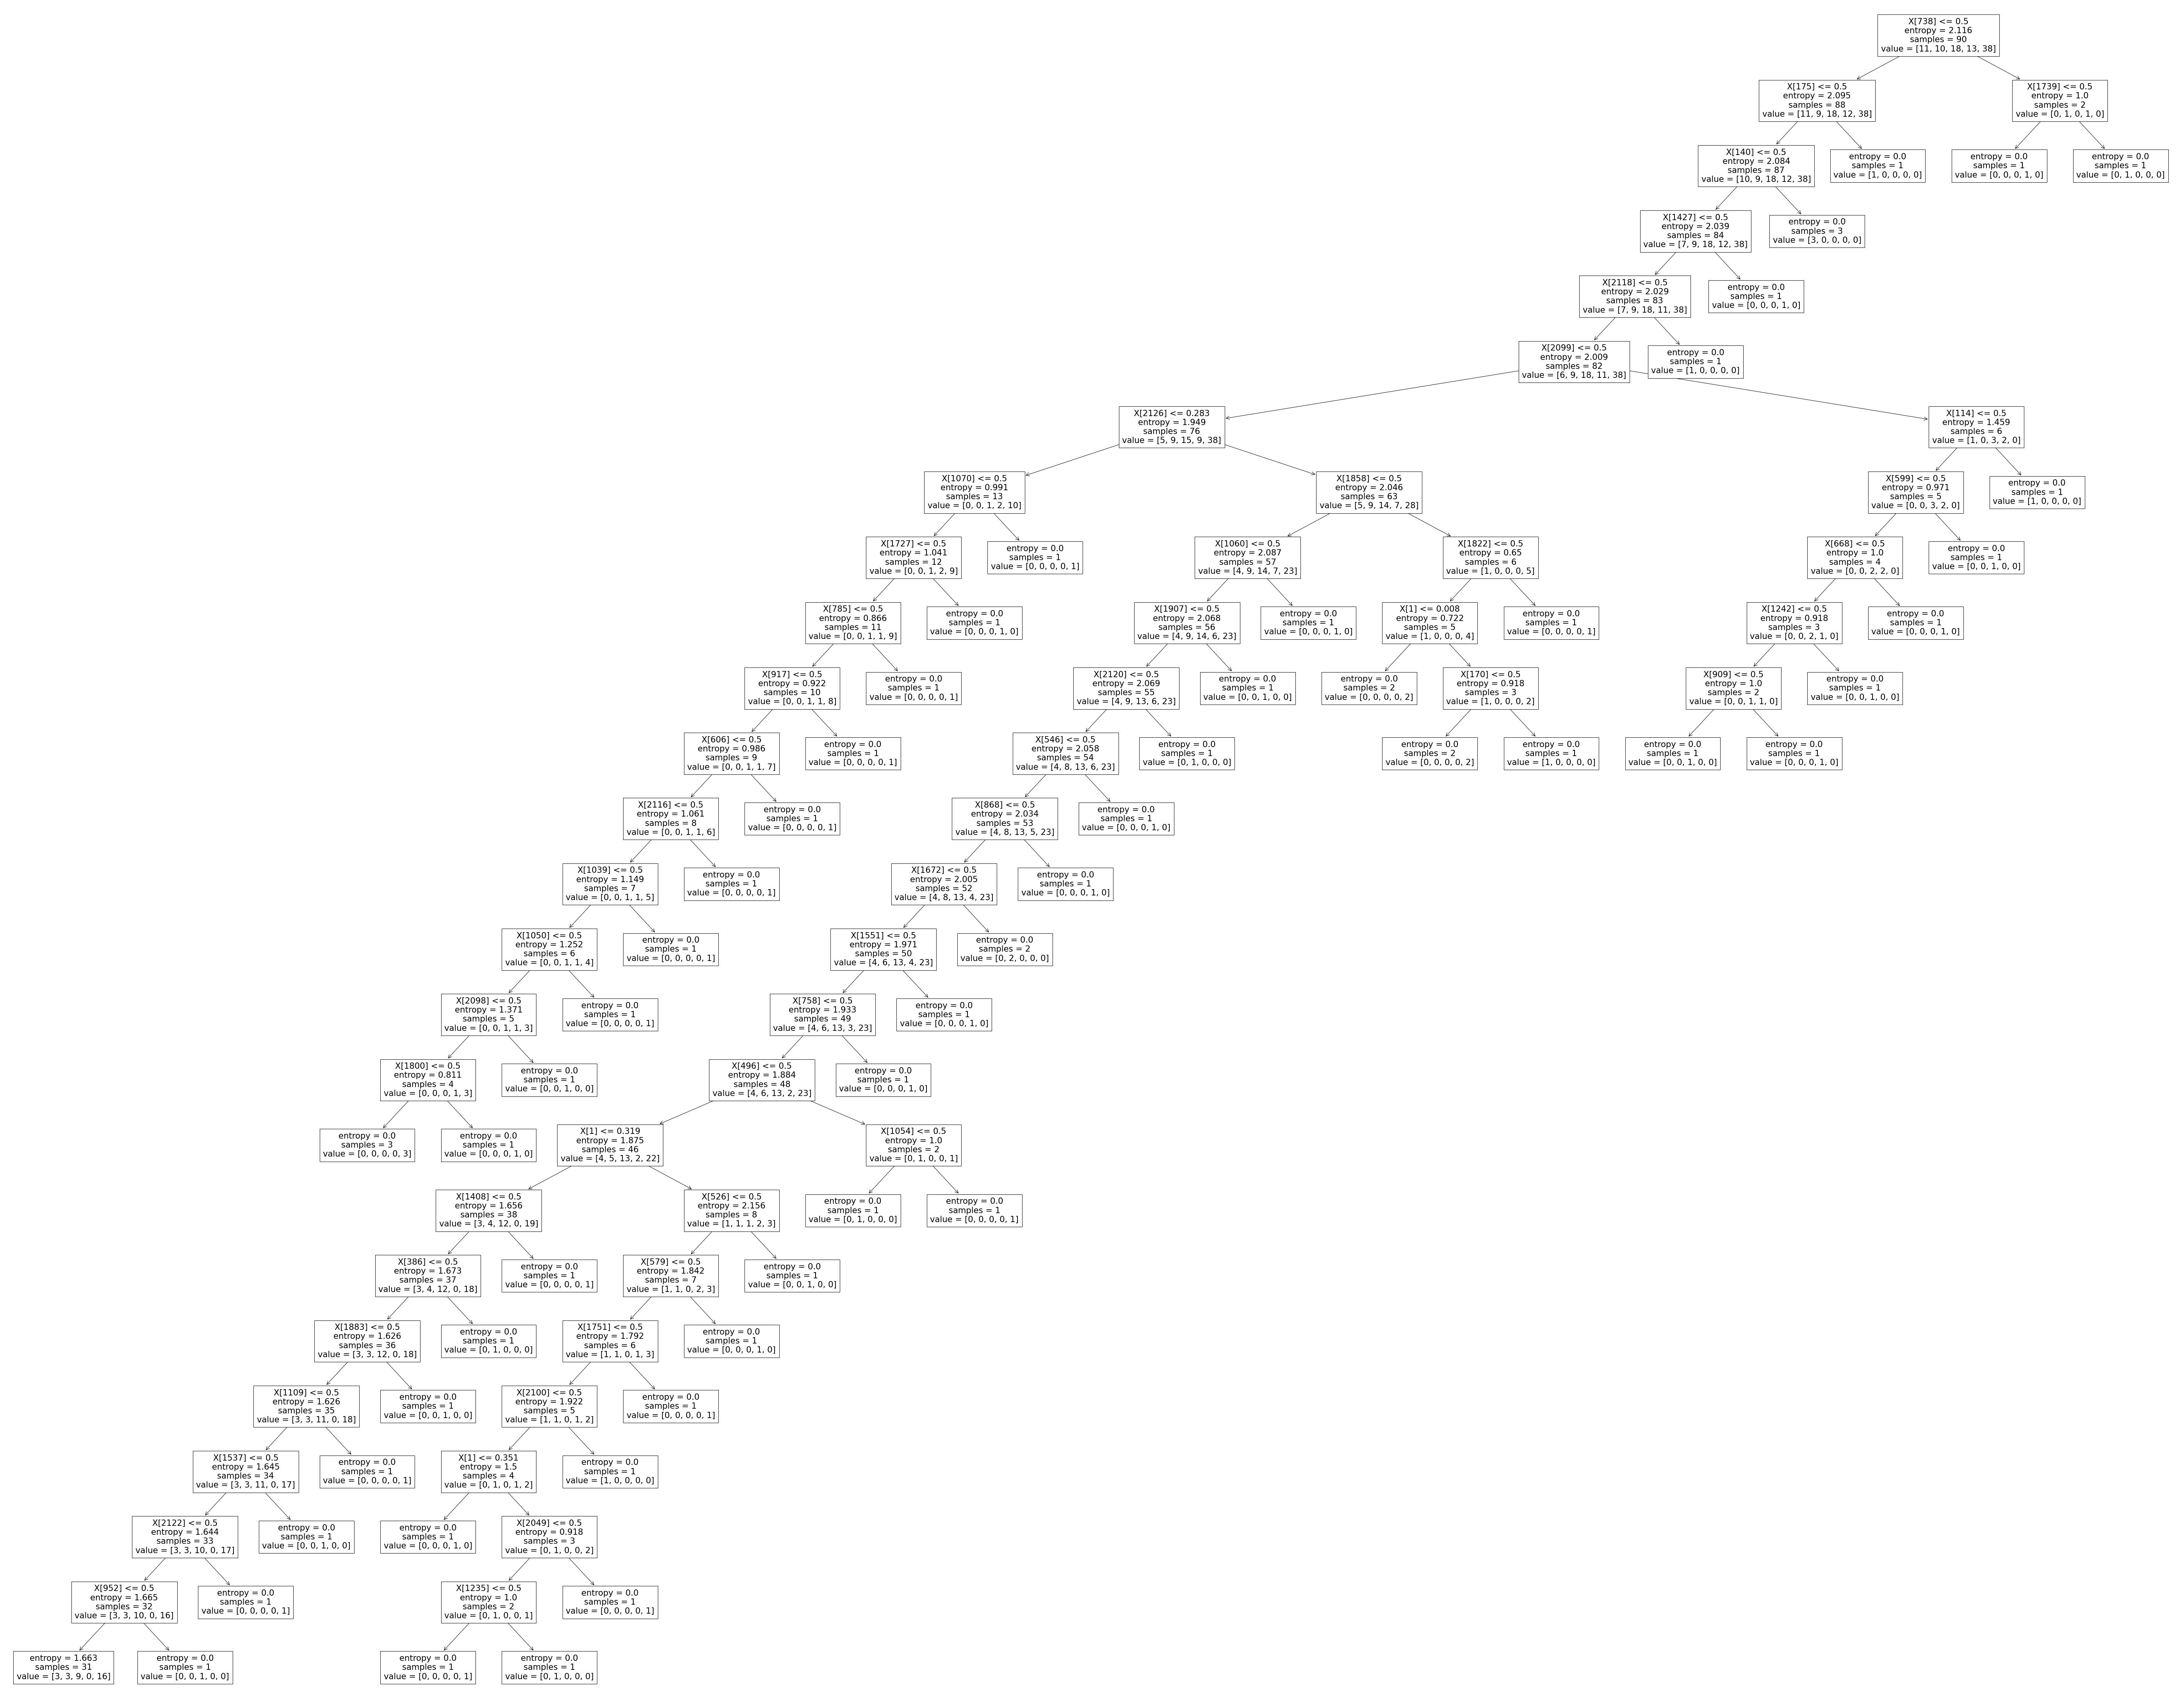

In [47]:
runDecisionTreeClassifier(filterDataFrame("person_id", 1642, train_df), 68, criterion, splitter, max_depth, max_features)